# <center>  Python for biologists
    
## Homework 10, Visualisation



## Правила

- **Не создавайте доп. веток в репозитории, не копируйте ноутбук.**
- Пишите код только там, где это от вас требуется (`# YOUR CODE HERE`)
- Не переименовывайте переменные, если они уже созданы. Происходят автопроверки.
- Перед отправкой проверьте что ваш ноутбук работает (юпитер-ноутбук). Нажмите на панели сверху `Kernel` -> `Restart Kernel and Run All Cells...`. Проверье что нет ошибок.
    

#### Погнали!

---


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# здесь любые импорты которые вам еще понадобятся (только здесь)

# Построение графиков по биоинформатическим данным

## Heatmap

- Данные: `DE_data_1.tsv`

<img src="heatmap.png" align="center" width="500" >

In [2]:
# Это мета-информация об образцах
meta = pd.DataFrame({'ENCFF240NOH': ('TAP pre-treated', 1), 
                     'ENCFF245SJH': ('TAP pre-treated', 2), 
                     'ENCFF321FEM': ('No treat', 1), 
                     'ENCFF368OTJ': ('No treat', 2), 
                     'ENCFF711LJB': ('AP-TAP pre-treated', 1), 
                     'ENCFF826APU': ('AP-TAP pre-treated', 2)}, index=['Sample', 'Replicate']).T
meta

,Sample,Replicate
ENCFF240NOH,TAP pre-treated,1
ENCFF245SJH,TAP pre-treated,2
ENCFF321FEM,No treat,1
ENCFF368OTJ,No treat,2
ENCFF711LJB,AP-TAP pre-treated,1
ENCFF826APU,AP-TAP pre-treated,2


In [4]:
# Читаем данные
de_data = pd.read_csv('data/DE_data_1.tsv', sep='\t', index_col=0)

# Отбираем 100 топовых генов
de_data['sum'] = de_data.sum(axis=1)
de_data = de_data.nlargest(100, columns='sum').drop(columns='sum')

# Готовим цветовую аннотацию
col_colors = meta['Sample'].map({'TAP pre-treated': '#0099CC', 'No treat': '#CCFFCC', 'AP-TAP pre-treated': '#66CCFF'})
col_colors.name = 'Sample'
rep_colors = meta['Replicate'].map({1: '#7247D7', 2: '#8D6DD7'})
rep_colors.name = 'Replicate'
col_colors = pd.concat([col_colors, rep_colors], axis=1)
col_colors

,Sample,Replicate
ENCFF240NOH,#0099CC,#7247D7
ENCFF245SJH,#0099CC,#8D6DD7
ENCFF321FEM,#CCFFCC,#7247D7
ENCFF368OTJ,#CCFFCC,#8D6DD7
ENCFF711LJB,#66CCFF,#7247D7
ENCFF826APU,#66CCFF,#8D6DD7


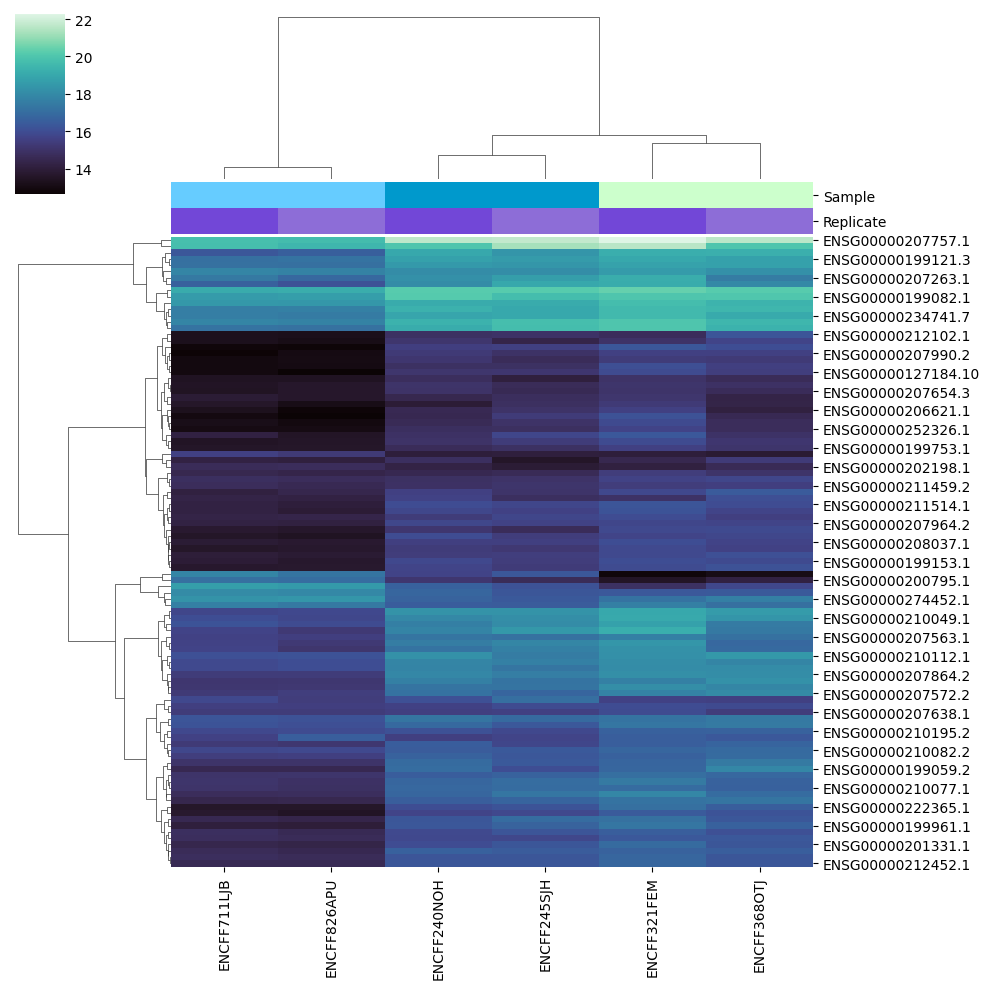

In [5]:
sns.clustermap(de_data,
               cmap="mako", method='ward',
               col_colors=col_colors)

## Volcano plot

- Данные: `DE_data_2.gz`

<img src="volcano_plot.png" align="center" width="500" >

In [7]:
from pandas.api.types import CategoricalDtype

# Читаем данные
de_data = pd.read_csv('data/DE_data_2.gz', sep='\t', index_col=0)

# Функции для классификации генов
def get_signif_type(pval):
    if pval <= 0.05:
        return 'Significantly'
    else:
        return 'Non-significantly'
    
def get_logfc_type(logfc):
    if logfc >= 0:
        return 'upregulated'
    else:
        return 'downregulated'   

# На будущее палетка для раскрашивания
palette = {'Significantly upregulated': 'tab:orange',
           'Significantly downregulated': 'tab:blue',
           'Non-significantly upregulated': 'tab:red',
           'Non-significantly downregulated': 'tab:green'
           }

# Классифицируем гены с помощью созданных функций
de_data['type'] = de_data.apply({'pval_corr': get_signif_type, 'logFC': get_logfc_type})\
                         .apply(" ".join, axis=1)
de_data['type'] = de_data['type'].astype(CategoricalDtype(categories=palette.keys(), ordered=True))

In [8]:
# Отбираем гены для подписей
top_2_up = de_data.query('type == "Significantly upregulated"').nlargest(2, columns='logFC').index.tolist()
top_2_down = de_data.query('type == "Significantly downregulated"').nsmallest(2, columns='logFC').index.tolist()
top_2 = top_2_up + top_2_down
top_2

['ZIC2', 'ZIC5', 'UMOD', 'MUC7']

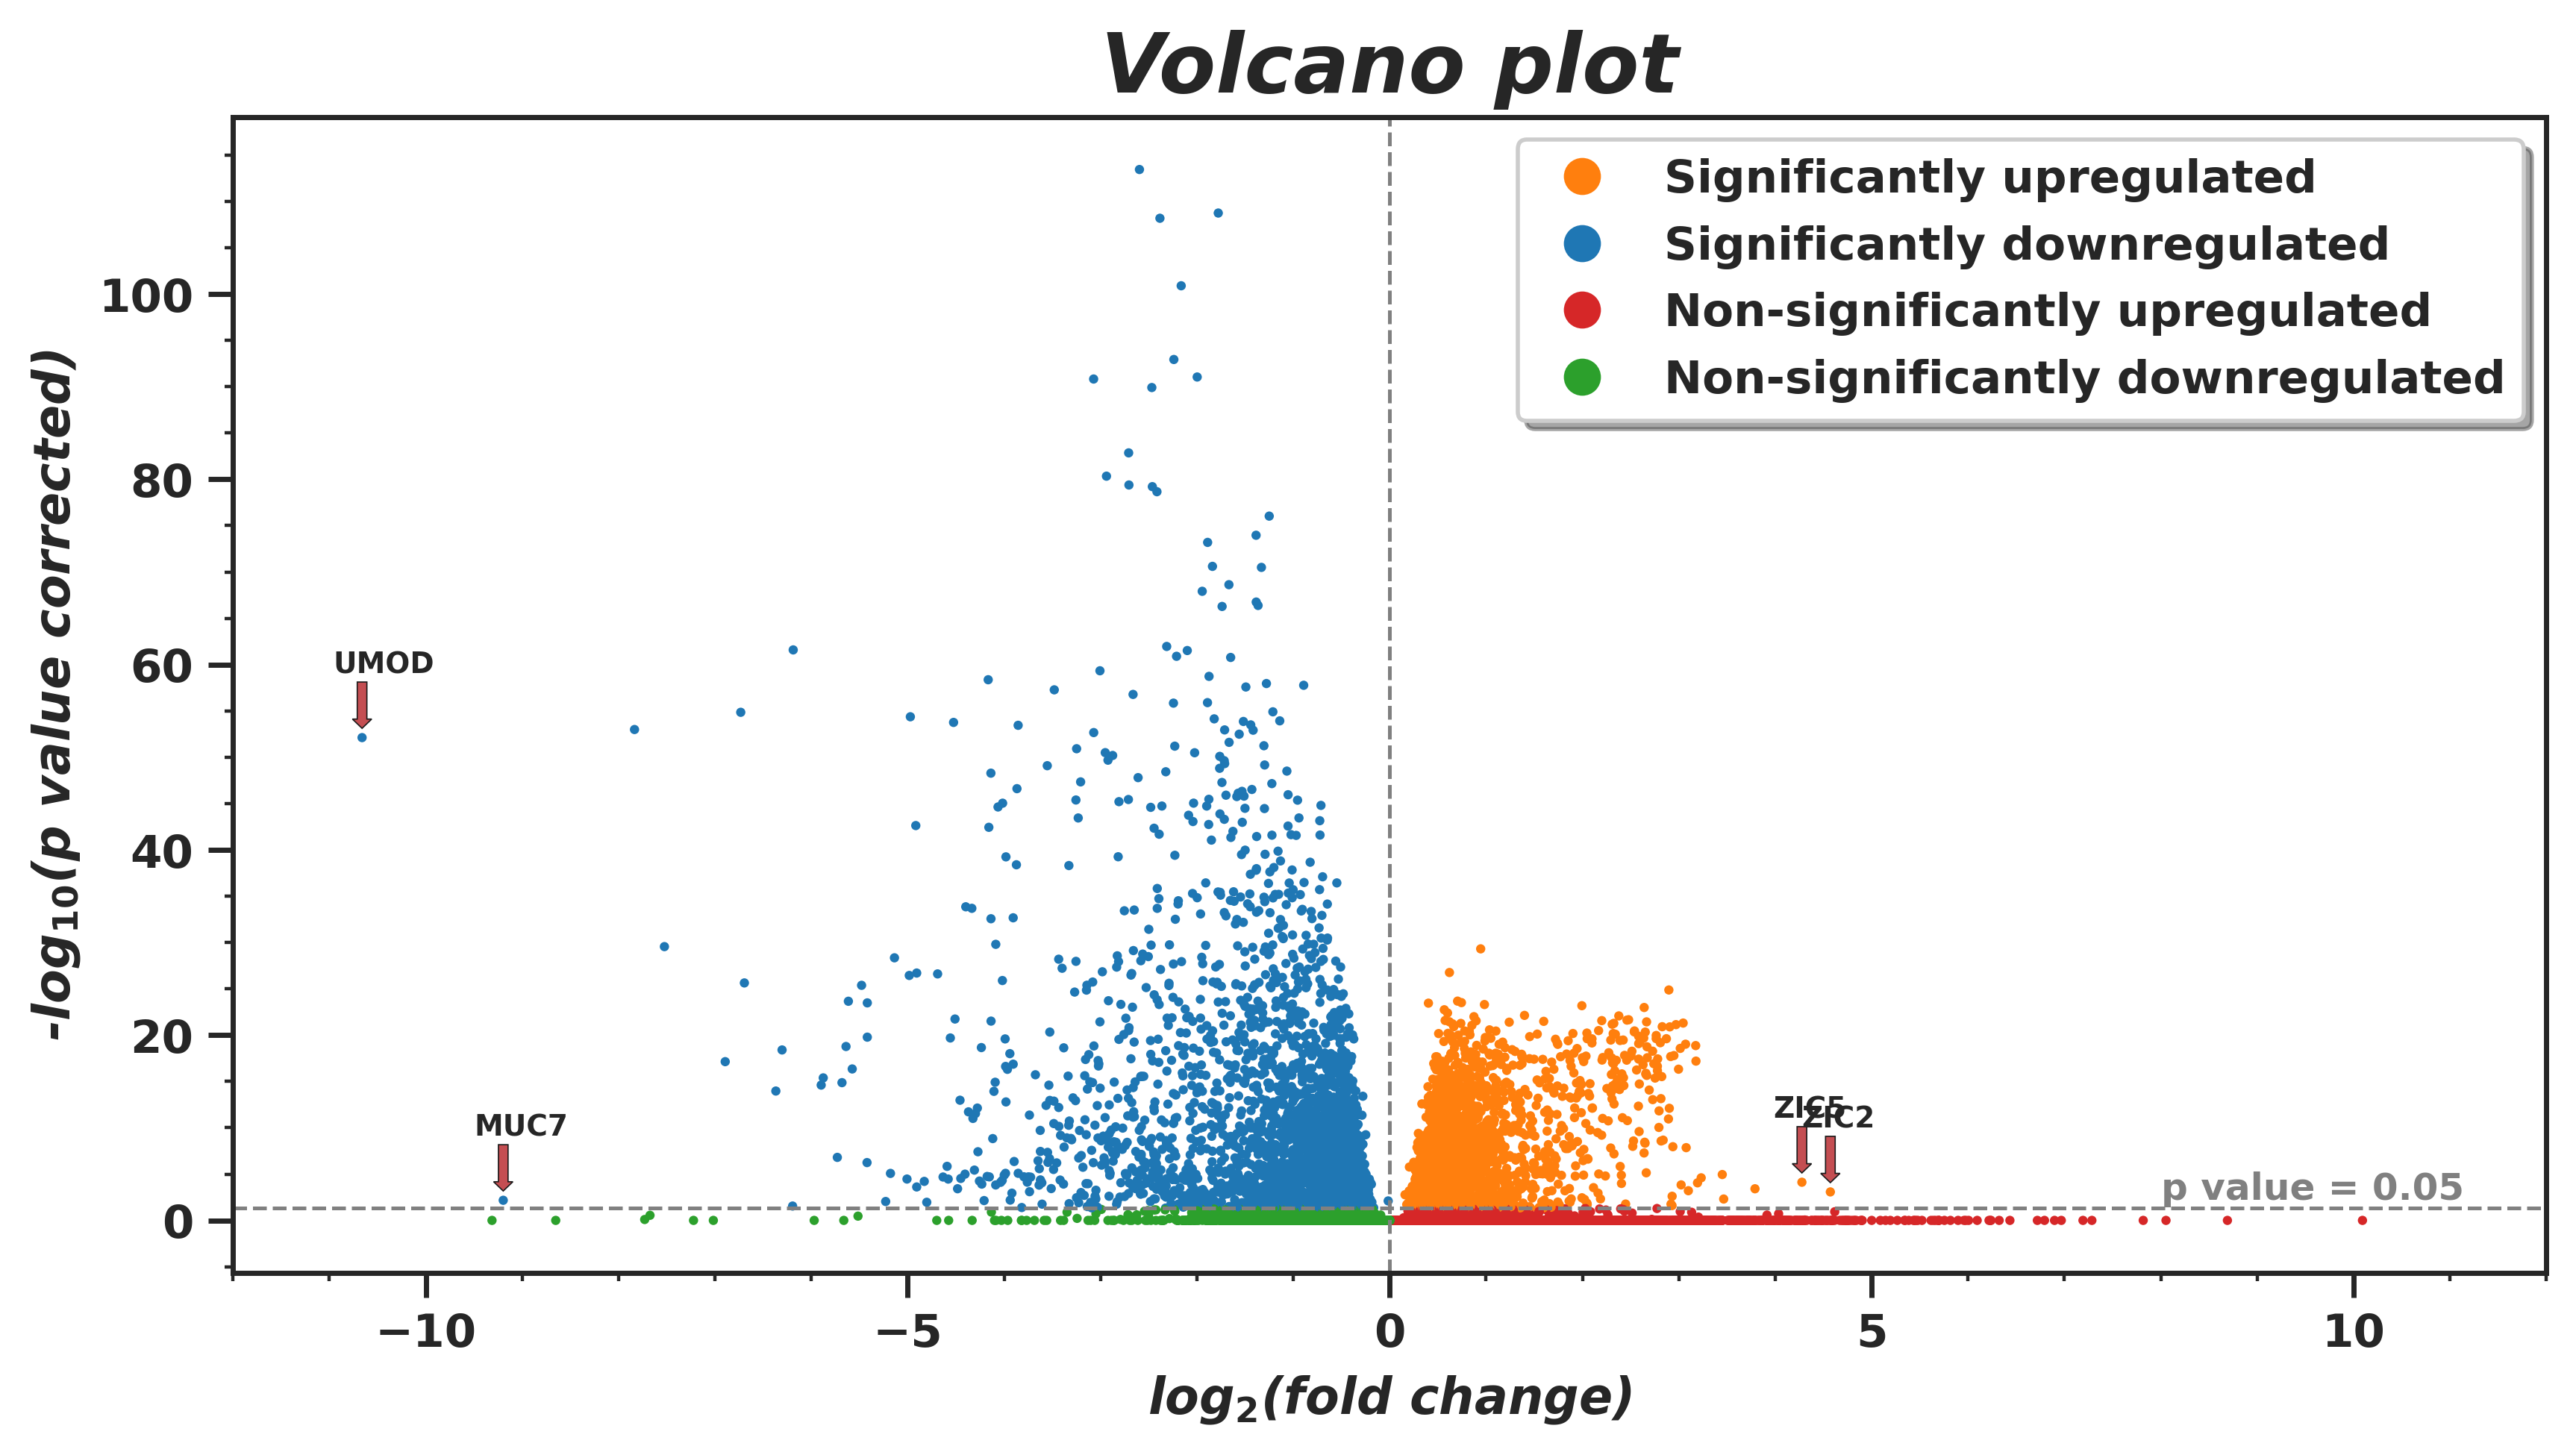

In [10]:
# Задаем общие настройки графика
sns.set_theme(style="ticks", font='sans-serif', rc={'figure.figsize': (10, 5.03)})
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['figure.dpi'] = 400
plt.rcParams['font.size'] = 3
plt.rcParams['font.weight'] = 'bold'

# Строим сам вулканчик
volcano = sns.scatterplot(data=de_data, 
                          x='logFC', y='log_pval', hue='type', 
                          palette=palette, s=5, linewidth=0)

# Все такие настройки для аннотации - добавляем через переменные
# с осмысленными именами! Чтобы было по минимуму магических чисел ниже по коду
arrow_vshift = 6
text_vshift = arrow_vshift + 1
text_hshift = -0.3

# Аннотируем топовые гены
for i, row in de_data.loc[top_2].iterrows():
    plt.text(row["logFC"] + text_hshift, row["log_pval"] + text_vshift, row.name, 
             fontfamily='sans-serif', size=7, weight='extra bold')
    plt.arrow(row["logFC"], row["log_pval"] + arrow_vshift, dx=0, dy=-arrow_vshift+2,
              head_width=0.2, head_length=1, width=0.1, linewidth=0.3, fc='r', ec='k')

# Аннотируем p-value
plt.text(8, -np.log10(0.05) + 1, 'p value = 0.05', c='grey', fontfamily='sans-serif', size=9, weight='bold')
plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--', linewidth=0.9)
plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.9)

# Настраиваем тики по x и y
xlim = int(np.ceil(de_data.logFC.abs().max())) + 1
plt.xlim(-xlim, xlim)
volcano.set_xticks(np.linspace(-xlim, xlim, xlim*2 + 1), minor=True)

y_prec = 5
ymin = int(y_prec * np.floor(de_data.log_pval.min() / y_prec - 1))
ymax = int(y_prec * np.floor(de_data.log_pval.max() / y_prec + 1))
volcano.set_yticks(np.linspace(ymin, ymax, int((ymax - ymin)/y_prec) + 1), minor=True)

volcano.tick_params(which='minor', length=2, width=0.8)

# Подписи графика и осей
volcano.set_title('Volcano plot', weight='black', style='italic', fontsize=20)
volcano.set_xlabel('log$_2$(fold change)', weight='black', style='italic')
volcano.set_ylabel('-log$_{10}$(p value corrected)', weight='black', style='italic')

plt.legend(shadow=True, title=None, markerscale=4)
plt.show()

## Сохранение графиков

In [ ]:
# По сути все сохранеяется просто через
plt.savefig('filename.EXT', dpi=300, bbox_inches='tight')
# Расширение EXT (png, pdf, svg,...) matplotlib сам распарсит и сделает как надо

---
# EDA

Покажите тут, что у вас получилось!

> По идее, вам нужно только запустить ячейку и всё. Но можете изменить датасет если хотите.

In [ ]:
# Можете вставить любой репрезентативный дата-фрейм на ваше усмотрение :)
data_dir = 'https://raw.githubusercontent.com/Python-BI-2023/course_materials/main/data/'
df = pd.read_csv(data_dir + 'titanic.csv')

In [ ]:
from my_awesome_eda import run_eda

run_eda(df)

---
# Мем